In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
%matplotlib inline  

/Users/Ethan/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Optimal Execution with Limit and Market Orders
## Alvaro Cartea and Sebastian Jaimungal
##### Abstract: We develop an optimal execution policy for an investor seeking to execute a large order using limit and market orders. The investor solves the optimal policy considering different restrictions on volume of both types of orders and depth at which limit orders are posted. We show how the execution policies perform when targeting the volume schedule of the Almgren-Chriss execution strategy. The different strategies considered by the investor outperform the Almgren-Chriss price with an average savings per share of about one to two and a half times the spread. This improvement over Almgren-Chriss is due to the strategies benefiting from the optimal mix of limit orders, which earn the spread, and market orders, which keep the investor's inventory schedule on target.

# Overview

- Describe basic models for financial markets (prices, trades)
- Formulate optimal trading with some stochastic optimal control problems
- Solve optimizations analytically and/or numerically  
- Illustrate solutions with examples and demonstrate results via Python code and plots
- Discuss extensions and alternative approaches when relevant

# Basics

- Limit Order Book
    - Bids & Asks
    - Limit orders vs. Market Orders
        - Passive vs. Aggressive
        - Price improvement vs. Guarantee of trade

- Algorithmic execution
    - Liquidation (acquisition): the task of selling (buying) $Q$ contracts/shares of asset beginning at time $t=0$ and ending at time $t=T.$
    - Performance measured, e.g., difference between average price and arrival price ("slippage"). 

In [2]:
# Graphic of LOB

# Model

The price process satisfies 

$$S_t = S_0 + \sigma(Z_t^+ - Z_t^-)$$

where $Z_t^{\pm}$ is a Poisson process.

- Poisson process $N = (N_t)_{0\leq t\leq T}\in Z_+$ with intensity $\lambda$: 
    - $N_0 = 0$
    - $N_t - N_0 \sim \textrm{Poisson}(\lambda t)$, i.e., 
    $$ P(N_t - N_0 = n) = \exp(-\lambda t)\frac{(\lambda t)^n}{n!} $$
    - $N_t - N_s$ and $N_v - N_u$ independent for disjoint intervals $[s, t]\cap [u, v]=\emptyset$.

In [3]:
def poisson_process(lam, size):
    '''Returns binary array A of length 'size' with A[i] = 1
    if event occurs in interval i and 0 otherwise
    '''
    M = []; n=0
    while n < size:
        n += round(random.expovariate(lam)*size)
        if n < size:
            M.append(n)
    return np.array([1 if i in M else 0 for i in range(size)])

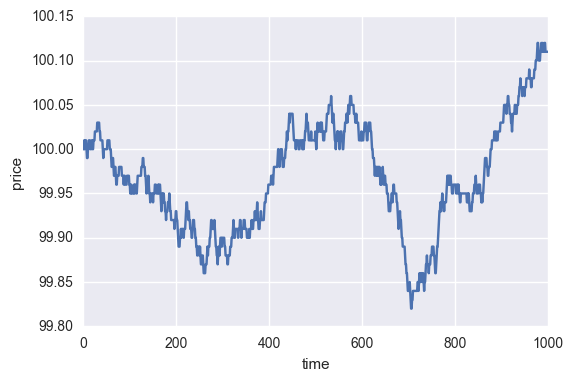

In [4]:
'''Simulate price process'''

S_0 = 100; sigma = 0.01; level_change_intensity = 500; timesteps = 1000;
S = np.zeros(timesteps + 1)
S[0] = S_0
Zp = poisson_process(lam=level_change_intensity, size=timesteps)
Zm = poisson_process(lam=level_change_intensity, size=timesteps)

for i in range(timesteps):
    S[i+1] = S[i] + sigma * (Zp[i] - Zm[i])

plt.plot(S); plt.xlabel('time'); plt.ylabel('price');

# Notation

- Lots of stochastic processes!
    - $\delta_t$: depth of limit order placement
    - $N_t$: limit order fills
        - Conditional on incoming order, exponential fill probability ($\kappa > 0$ so decreasing as $\delta$ increasing): 
        $$ P(\textrm{fill}\mid\textrm{incoming MO}) = \exp(-\kappa \delta_t). $$
        - Poisson with intensity $\lambda \exp(-\kappa\delta_t)$
    - $M_t$: market order placements (fills)        
        - Can be described by times $t^\prime_1\leq\cdots\leq t^\prime_K$: 
        $$ M_t = \sum_{k=1}^K 1_{t^\prime_k\leq t} $$
    - $X_t$: wealth, i.e., \$ collected thus far at $t$ from liquidating 
$$ dX_t = (S_{t} + \delta_{t})dN_t + (S_{t} - \Delta)dM_t $$ 
        - $\Delta$ is the half-spread
    - $q_t$: inventory
        - $q_t = Q - N_t - M_t$
 - Goal is to set up optimization problem with controls $\delta_t$ and $\mathbf{\tau}$

# Optimal Control 

Consider value function $H$:

$$ H(x, S, q) = \sup_{\mathbf{\tau}, \delta_t} \mathbb{E}\left[ X_T^\delta + G(Q_T^\delta) - \phi\int_0^T F(Q_s^\delta)\,ds \right] $$

In other words, maximize expected terminal wealth, subject to the following penalties:

- A function $G$ of the terminal quantity $Q_T$ 
    - e.g., $Q_T(S_T - \beta Q_T)$ so $\rightarrow -\infty$ as $\beta\rightarrow\infty$
- Running penalty of a function $F$ of the inventory over $[0, T]$
    - e.g., $F(Q_s) = (Q_s - Q_{\textrm{target}})^2$
    
Two control variables:
- $\delta$
    - depth of limit order placement
    - solution $\delta(q, t)$ depends on quantity and time
    - always resting an order throughout    
- $\tau=\tau_1,\ldots,\tau_Q$
    - trigger times for market orders    
    - solution $\tau_q$ depends on quantity
    - execute market order as soon as $t\geq\tau_q$    